# Inteligencia Artificial<a class="tocSkip">
## Machine Learning <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

# Predicción de Series Temporales NN - Embeddings

## Usaremos Keras y Tensorflow

Importamos las Librerías que vamos a utilizar

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

### Cargamos nuestro Dataset

In [31]:
df = pd.read_csv('time_series.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','unidades'])
df.head()

,unidades
fecha,
2017-01-02,236
2017-01-03,237
2017-01-04,290
2017-01-05,221
2017-01-07,128


In [32]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2017-01-02,236,0,1
2017-01-03,237,1,1
2017-01-04,290,2,1
2017-01-05,221,3,1
2017-01-07,128,5,1


In [33]:
df.describe()

,unidades,weekday,month
count,604.000000,604.000000,604.000000
mean,215.935430,2.644040,6.304636
std,75.050304,1.818674,3.312359
min,51.000000,0.000000,1.000000
25%,171.000000,1.000000,3.000000
50%,214.000000,3.000000,6.000000
75%,261.250000,4.000000,9.000000
max,591.000000,6.000000,12.000000


# Preprocesado de los datos

In [34]:
PASOS=7
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [35]:
# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df['weekday']
reframed['month']=df['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df['weekday'][i+8]
    reframed['month'].loc[contador]=df['month'][i+8]
    contador=contador+1
reframed.head()



C:\Users\joser\AppData\Local\Temp\ipykernel_576552\2696049370.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed['weekday'].loc[contador]=df['weekday'][i+8]
C:\Users\joser\AppData\Local\Temp\ipykernel_576552\2696049370.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed['month'].loc[contador]=df['month'][i+8]


,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month
0,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,3.0,1.0
1,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,4.0,1.0
2,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,5.0,1.0
3,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,0.0,1.0
4,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444,1.0,1.0


In [36]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado

C:\Users\joser\AppData\Local\Temp\ipykernel_576552\569248616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reordenado.dropna(inplace=True)


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,3.0,1.0,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
1,4.0,1.0,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
2,5.0,1.0,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
3,0.0,1.0,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
4,1.0,1.0,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444
...,...,...,...,...,...,...,...,...,...,...
591,0.0,11.0,-0.777778,-0.422222,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407
592,1.0,11.0,-0.422222,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667
593,2.0,11.0,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667,-0.374074
594,3.0,11.0,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667,-0.374074,-0.511111


## Dividimos en set de Entrenamiento y Validación

In [37]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[595-30:595]
valid_target=target_data[595-30:595]

training_data = training_data[0:595]
target_data=target_data[0:595]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(595, 9) (595,) (30, 9) (30,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red Feedforward con Embeddings

### Tenemos como entradas 9 columnas (2 embeddings y 7 pasos)

In [38]:
def crear_modeloEmbeddings():
    emb_dias = 2 #tamanio profundidad de embeddings
    emb_meses = 4

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model


## Entrenamos nuestra máquina

In [39]:
EPOCHS=40

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dias (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 meses (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 2)         16          ['dias[0][0]']                   
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 4)         52          ['meses[0][0]']                  
                                                                                            

## Visualizamos Resultados

1/1 [==============================] - 0s 86ms/step
30


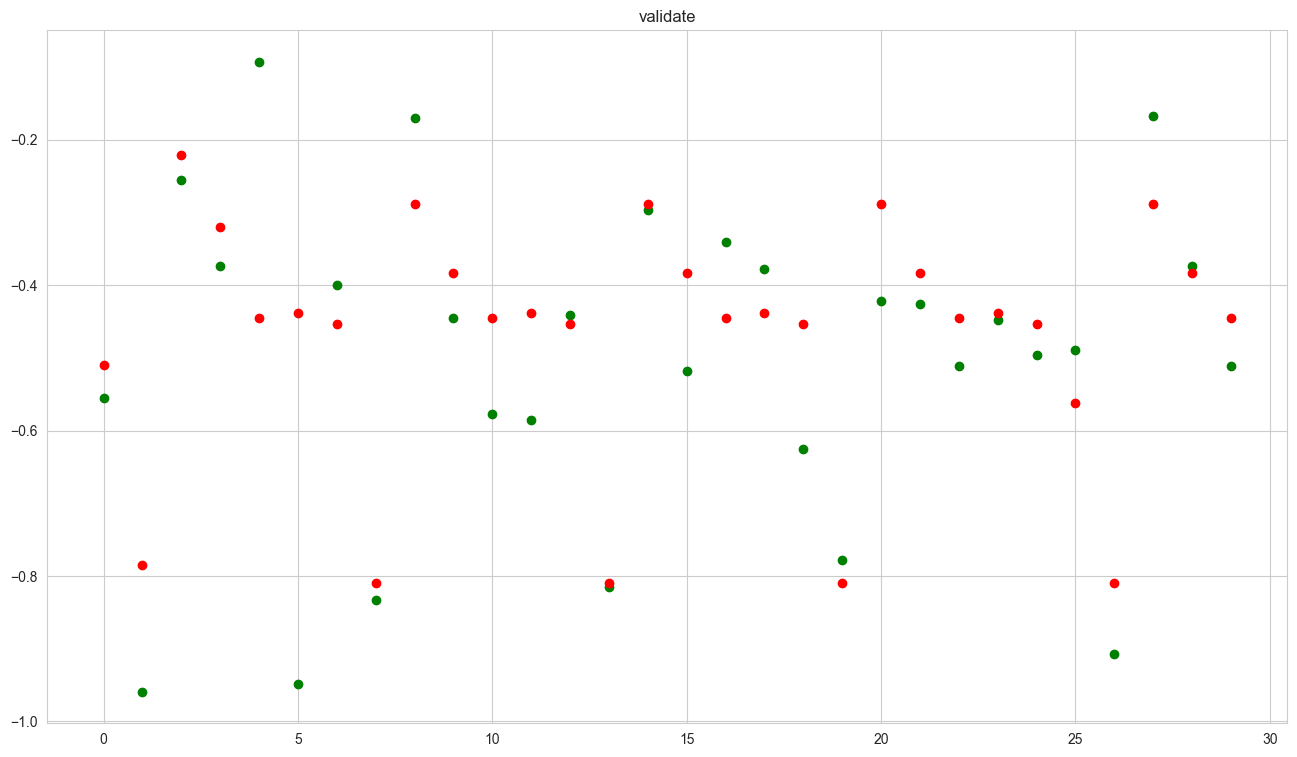

In [40]:
results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()


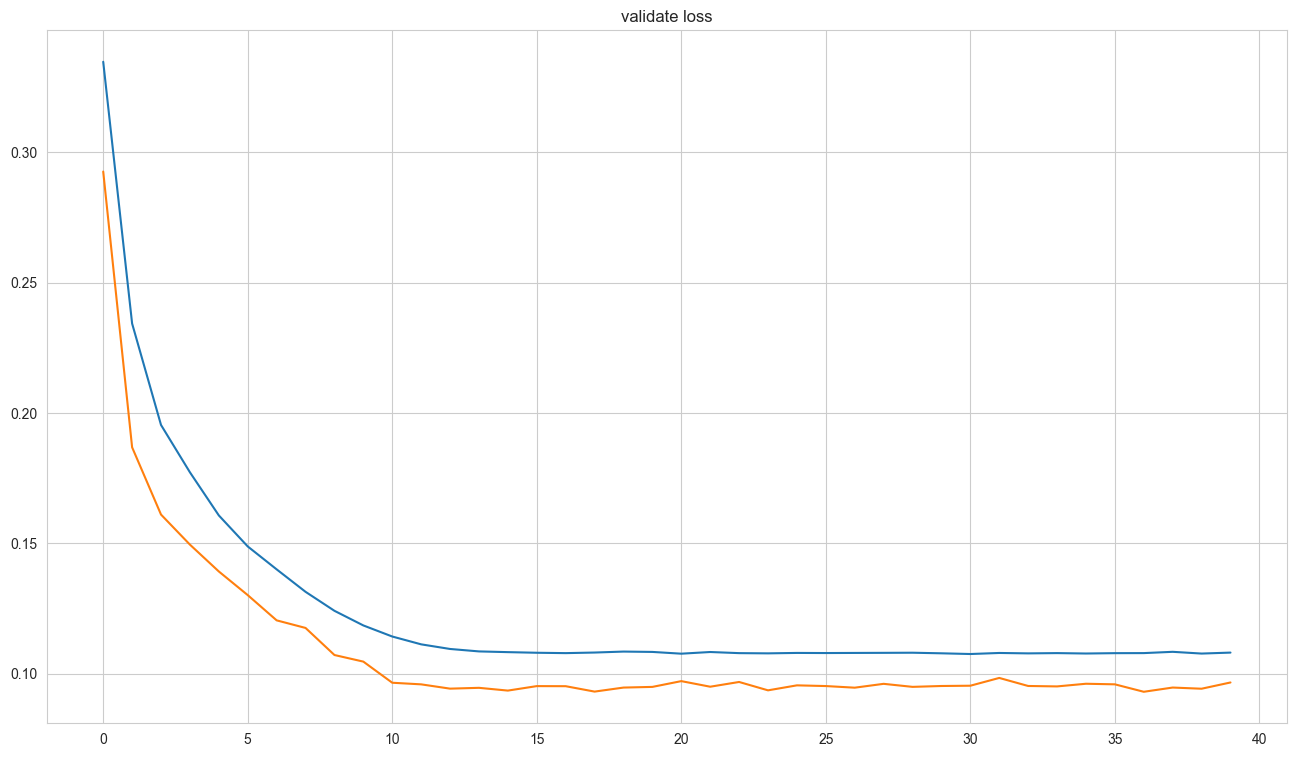

In [41]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

KeyError: 'mean_squared_error'

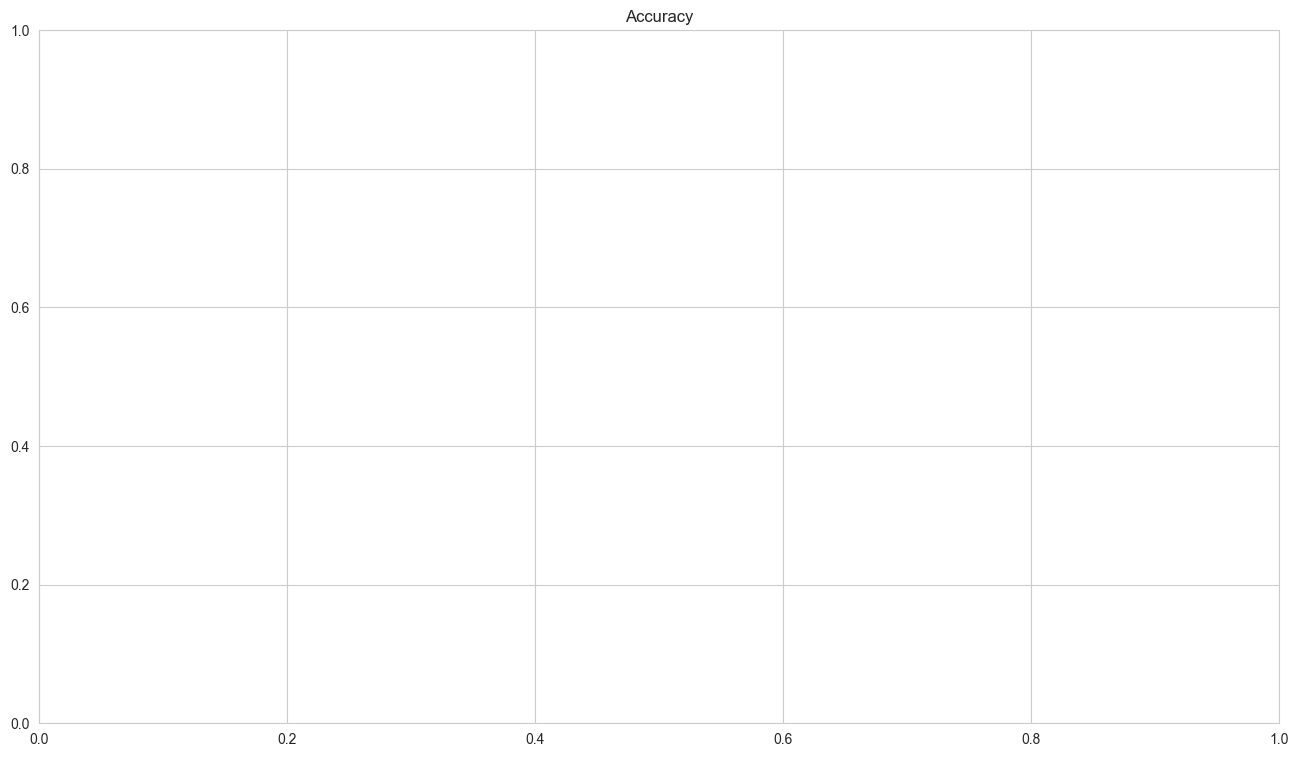

In [44]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [45]:
compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(12)

,real,prediccion,diferencia
0,171.000000,183.255356,-12.255356
1,62.000004,109.152817,-47.152813
2,252.000000,261.482697,-9.482697
3,220.000000,234.799393,-14.799393
4,296.000000,200.663071,95.336929
5,64.999992,202.529556,-137.529572
6,213.000000,198.518936,14.481064
7,95.999992,102.444153,-6.444160
8,275.000000,243.041931,31.958069
9,201.000000,217.543457,-16.543457


In [46]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,184.733337,193.923248,-9.189893
std,61.144791,45.524235,37.861008
min,62.000004,102.444153,-137.529572
25%,163.500000,198.518936,-24.248877
50%,194.500000,200.663071,-10.500816
75%,219.750000,217.543457,7.287151
max,296.000000,261.482697,95.336929


<Axes: >

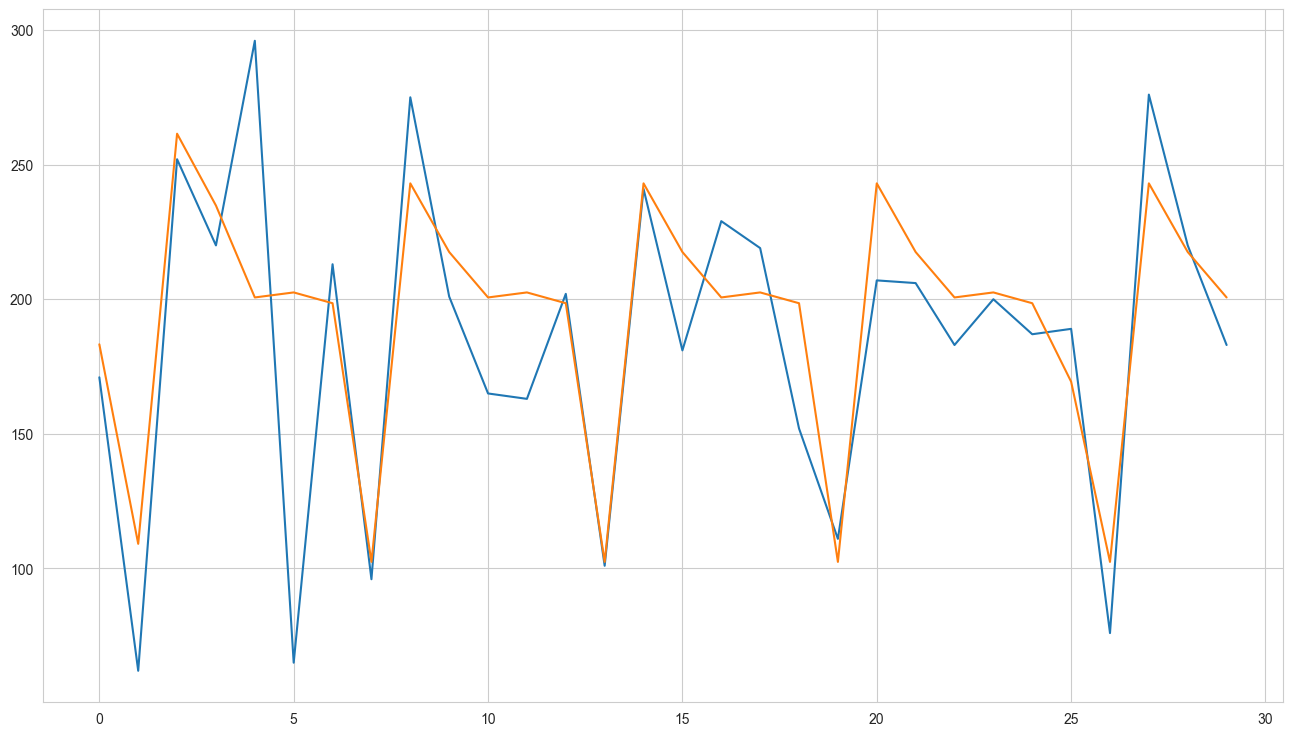

In [47]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Pronóstico

A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [48]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

,unidades,weekday,month
fecha,,,
2018-11-16,152,4,11
2018-11-17,111,5,11
2018-11-19,207,0,11
2018-11-20,206,1,11
2018-11-21,183,2,11
2018-11-22,200,3,11
2018-11-23,187,4,11
2018-11-24,189,5,11
2018-11-25,76,6,11


## Preparamos los datos para Test

In [49]:
# load dataset
values = ultimosDias['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=ultimosDias['weekday']
reframed['month']=ultimosDias['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=ultimosDias['weekday'][i+8]
    reframed['month'].loc[contador]=ultimosDias['month'][i+8]
    contador=contador+1
reframed.head()

reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)'] ]
reordenado.dropna(inplace=True)
reordenado

C:\Users\joser\AppData\Local\Temp\ipykernel_576552\3211569656.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed['weekday'].loc[contador]=ultimosDias['weekday'][i+8]
C:\Users\joser\AppData\Local\Temp\ipykernel_576552\3211569656.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed['month'].loc[contador]=ultimosDias['month'][i+8]
C:\Users\joser\AppData\Local\Temp\ipykernel_576552\3211569656.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
0,6.0,11.0,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
1,0.0,11.0,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
2,1.0,11.0,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
3,2.0,11.0,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
4,3.0,11.0,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
5,4.0,11.0,0.24,0.11,0.13,-1.00,1.00,0.44,0.07


In [50]:
values = reordenado.values
x_test = values[5:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = reordenado.weekday[len(reordenado.index)-1]
ultDiaSemana

(1, 1, 9)
[[[ 4.         11.          0.24000001  0.11000001  0.13
   -1.          1.          0.44000006  0.06999993]]]


4.0

In [51]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i+2] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][0]=ultDiaSemana
    x_test[0][0][1]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

## Pronóstico para la "próxima semana"

In [52]:
results=[]
for i in range(7):
    dia=np.array([x_test[0][0][0]])
    mes=np.array([x_test[0][0][1]])
    valores=np.array([x_test[0][0][2:9]])
    parcial=model.predict([dia, mes, valores])
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)
    

InvalidArgumentError: Graph execution error:

Detected at node 'model_1/concatenate_1/concat' defined at (most recent call last):
    File "C:\Users\joser\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\joser\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\joser\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\joser\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\joser\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\joser\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\joser\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\joser\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\joser\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\joser\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\joser\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\joser\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\joser\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\joser\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\joser\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell
      result = self._run_cell(
    File "C:\Users\joser\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell
      result = runner(coro)
    File "C:\Users\joser\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\joser\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\joser\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\joser\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\joser\AppData\Local\Temp\ipykernel_576552\4062969779.py", line 6, in <module>
      parcial=model.predict([dia, mes, valores])
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\layers\merging\base_merge.py", line 178, in call
      return self._merge_function(inputs)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\layers\merging\concatenate.py", line 126, in _merge_function
      return backend.concatenate(inputs, axis=self.axis)
    File "C:\Users\joser\anaconda3\lib\site-packages\keras\backend.py", line 3313, in concatenate
      return tf.concat([to_dense(x) for x in tensors], axis)
Node: 'model_1/concatenate_1/concat'
ConcatOp : Expected concatenating dimensions in the range [-2, 2), but got 2
	 [[{{node model_1/concatenate_1/concat}}]] [Op:__inference_predict_function_9957]

## Re-Convertimos los resultados

In [53]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[]


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Visualizamos el pronóstico

In [28]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico_embeddings.csv')

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

In [98]:
prediccion1SemanaDiciembre

,pronostico
0,132.725057
1,143.071309
2,129.761916
3,99.815734
4,163.210682
5,150.880790
6,143.121046


**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).